In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [0]:
def byte_to_tf_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def float_to_tf_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_to_tf_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
def save_tf_records(imgList, labelList, out_path):
    writer = tf.python_io.TFRecordWriter(out_path)
 
    for i in range(labelList.shape[0]):
   
        example = tf.train.Example(features=tf.train.Features(
            feature={'image': byte_to_tf_feature(imgList[i].tostring()),
                     'labels': int64_to_tf_feature(
                         labelList[i])
                     }))
 
        writer.write(example.SerializeToString())
 
    writer.close()

In [0]:
save_tf_records(x_train, y_train, './training.tf_records')
save_tf_records(x_test, y_test, './testing.tf_records')

In [0]:
def load_tf_records(path,imgShape):
    dataset = tf.data.TFRecordDataset(path)
 
    def parser(record):
        featDefn = {
            'image': tf.FixedLenFeature(shape=[], dtype=tf.string),
            'labels': tf.FixedLenFeature(shape=[], dtype=tf.int64),
        }
 
        example = tf.parse_single_example(record, featDefn)
        img = tf.decode_raw(example['image'], tf.float32)
        img = tf.reshape(img, ( imgShape[0], imgShape[1], imgShape[2]))
        label = tf.cast(example['labels'], tf.int64)
        return img, label
 
    dataset = dataset.map(parser)
    return dataset


In [0]:
import numpy as np

def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
    inp_shape = tf.shape(input_)
    size = tf.shape(replacement)
    padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
    replacement_pad = tf.pad(replacement, padding)
    mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
    return tf.where(mask, replacement_pad, input_)

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=1, pixel_level=False):
  """ It returns eraser function to apply cutout on input image

    Parameters:
    p   : probability of cutout application
    s_l : min cutout area proportion
    s_h : max cutout area proportion
    r_1 : min aspect ratio
    r_2 : max aspect ratio
    v_l : min value for erased area
    v_h : max value for erased area
    pixel_level(bool) : whether to apply random pixel values in cutout area

    Returns:
    eraser function which applies cutout to the input image.

  """

  def eraser(input_img: tf.Tensor) -> tf.Tensor:
      dtype = input_img.dtype
      inp_shape = tf.shape(input_img)
      img_h = inp_shape[0]
      img_w = inp_shape[1]
      img_c = inp_shape[2]
      
      p_1 = tf.random.uniform(shape = [],dtype=tf.float32)

      if p_1 > p:
          return input_img

      
      s = tf.random.uniform(shape=[],minval=s_l,maxval=s_h,dtype=tf.float32) * tf.cast(img_h,tf.float32) * tf.cast(img_w,tf.float32)
      r = tf.random.uniform(shape=[],minval=r_1,maxval=r_2,dtype=tf.float32)
      w = tf.cast(tf.math.sqrt(s / r),tf.int32)
      h = tf.cast(tf.math.sqrt(s * r),tf.int32)
      left = tf.random.uniform(shape=[],minval=0,maxval=img_w,dtype=tf.int32)
      top = tf.random.uniform(shape=[],minval=0,maxval=img_h,dtype=tf.int32) 

      if left + w > img_w:
        w = img_w - left - 1
      if top + h > img_h:
        h = img_h - top -  1

      replaceBlock = tf.random.uniform([h, w, img_c], minval=v_l, maxval=v_h, dtype=dtype)           
      
      input_img = replace_slice(input_img, replaceBlock, [top, left, 0])
      return input_img

  return eraser

In [0]:
eraser = get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,v_l=0.0, v_h=1.0, pixel_level=False)


In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1
last_batch_size = len_train % BATCH_SIZE

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
data_aug2 = lambda x, y: (tf.image.random_flip_left_right(cutout(tf.random_crop(x, [32, 32, 3]))), y)
data_aug3 = lambda x, y: (tf.image.random_flip_left_right(eraser(tf.random_crop(x, [32, 32, 3]))), y)

In [18]:
t = time.time()
test_set = load_tf_records('./testing.tf_records',[32,32,3]).batch(BATCH_SIZE)

trainLosses = []
testLosses = []
trainAccuracy = []
testAccuracy = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = load_tf_records('./training.tf_records',[40,40,3])
  train_set = train_set.map(data_aug3).shuffle(len_train).batch(BATCH_SIZE)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  currentTestAcc = (test_acc/len_test) 
  currentTrainAcc = (train_acc/len_train) 
  testAccuracy.append(currentTestAcc)  
  trainAccuracy.append(currentTrainAcc)
  testLosses.append(test_loss / len_test)
  trainLosses.append(train_loss / len_train)
  
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



epoch: 1 lr: 0.08 train loss: 1.6212989068603516 train acc: 0.41642 val loss: 1.5495251861572266 val acc: 0.4888 time: 53.62379693984985



epoch: 2 lr: 0.16 train loss: 0.9322278887939454 train acc: 0.66808 val loss: 1.0565307373046875 val acc: 0.636 time: 96.8042733669281



epoch: 3 lr: 0.24 train loss: 0.7326016027832031 train acc: 0.74168 val loss: 0.7196786499023438 val acc: 0.7504 time: 139.74643182754517



epoch: 4 lr: 0.32 train loss: 0.6177993383789062 train acc: 0.78582 val loss: 0.9259959014892578 val acc: 0.7138 time: 182.7359697818756



epoch: 5 lr: 0.4 train loss: 0.5560672378540039 train acc: 0.81042 val loss: 0.9517856353759766 val acc: 0.7171 time: 225.37982821464539



epoch: 6 lr: 0.37894736842105264 train loss: 0.4619262612915039 train acc: 0.84032 val loss: 0.6682131881713868 val acc: 0.773 time: 268.3598518371582



epoch: 7 lr: 0.35789473684210527 train loss: 0.3852483792114258 train acc: 0.86656 val loss: 0.4683719551086426 val acc: 0.8504 time: 311.43494868278503



epoch: 8 lr: 0.33684210526315794 train loss: 0.33794429153442385 train acc: 0.88238 val loss: 0.3856680358886719 val acc: 0.8718 time: 353.99969387054443



epoch: 9 lr: 0.31578947368421056 train loss: 0.3001418786621094 train acc: 0.89538 val loss: 0.45352921600341795 val acc: 0.8573 time: 397.4988946914673



epoch: 10 lr: 0.2947368421052632 train loss: 0.27059969940185546 train acc: 0.90456 val loss: 0.3970686485290527 val acc: 0.8691 time: 440.85006856918335



epoch: 11 lr: 0.2736842105263158 train loss: 0.24564445358276368 train acc: 0.91604 val loss: 0.35208374557495115 val acc: 0.8867 time: 484.4377508163452



epoch: 12 lr: 0.25263157894736843 train loss: 0.21847057388305663 train acc: 0.92322 val loss: 0.3091736877441406 val acc: 0.8951 time: 527.7246146202087



epoch: 13 lr: 0.23157894736842108 train loss: 0.19959617973327637 train acc: 0.93068 val loss: 0.3008370979309082 val acc: 0.9054 time: 570.9325716495514



epoch: 14 lr: 0.2105263157894737 train loss: 0.1808300096130371 train acc: 0.93852 val loss: 0.3217539016723633 val acc: 0.8957 time: 614.0070445537567



epoch: 15 lr: 0.18947368421052635 train loss: 0.16463562782287597 train acc: 0.94378 val loss: 0.29753061294555666 val acc: 0.9078 time: 656.5553786754608



epoch: 16 lr: 0.16842105263157897 train loss: 0.1496383275604248 train acc: 0.94786 val loss: 0.27975792846679687 val acc: 0.9133 time: 699.2174808979034



epoch: 17 lr: 0.1473684210526316 train loss: 0.13595787147521973 train acc: 0.95352 val loss: 0.284481339263916 val acc: 0.9116 time: 741.748948097229



epoch: 18 lr: 0.12631578947368421 train loss: 0.12432734428405762 train acc: 0.95726 val loss: 0.28458071517944333 val acc: 0.9114 time: 784.1419034004211



epoch: 19 lr: 0.10526315789473689 train loss: 0.1124570125579834 train acc: 0.9617 val loss: 0.24206518363952637 val acc: 0.9263 time: 826.2462487220764



epoch: 20 lr: 0.08421052631578951 train loss: 0.09924960350036621 train acc: 0.96716 val loss: 0.24499546966552735 val acc: 0.9278 time: 868.5365564823151



epoch: 21 lr: 0.06315789473684214 train loss: 0.09156286041259766 train acc: 0.9694 val loss: 0.23105659942626952 val acc: 0.9318 time: 911.1356649398804



epoch: 22 lr: 0.04210526315789476 train loss: 0.08163550338745117 train acc: 0.97306 val loss: 0.2259804141998291 val acc: 0.9301 time: 953.2502439022064



epoch: 23 lr: 0.02105263157894738 train loss: 0.07544632858276368 train acc: 0.97596 val loss: 0.22168368263244628 val acc: 0.9308 time: 996.1093509197235



epoch: 24 lr: 0.0 train loss: 0.0702882780456543 train acc: 0.97746 val loss: 0.22059149284362792 val acc: 0.9336 time: 1038.568026304245


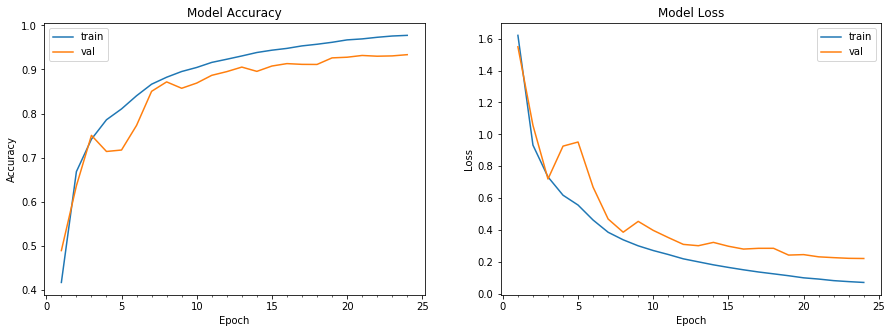

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))   # define a plot with 1 row and 2 columns of subplots
    
# summarize history for accuracy
axs[0].plot(range(1,len(trainAccuracy)+1),trainAccuracy)
axs[0].plot(range(1,len(testAccuracy)+1),testAccuracy)
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(np.arange(1,len(trainAccuracy)+1),len(trainAccuracy)/10)
axs[0].legend(['train', 'val'], loc='best')

# summarize history for loss
axs[1].plot(range(1,len(trainLosses)+1),trainLosses)
axs[1].plot(range(1,len(testLosses)+1),testLosses)
axs[1].set_title('Model Loss') 
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(np.arange(1,len(trainLosses)+1),len(trainLosses)/10)
axs[1].legend(['train', 'val'], loc='best')
plt.show()